In [ ]:
import tensorflow as tf
from tensorflow.keras import layers 
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import os
import random
import imageio

from tensorflow import summary
from tensorflow.keras.callbacks import TensorBoard


In [2]:
BUFFER_SIZE = 9673
BATCH_SIZE = 8

## Load and preprocess PNG images

In [3]:
def preprocess_image(image):
    image= tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [256, 256])
    image = (image-127.5)/127.5
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

## Build IW image database for training and testing

In [ ]:
os.getcwd()

all_patient_pd_tse = []

#Access patient folders
def get_pd_folders(root_dir):
    pd_folders = [] #In the scope of this code "pd" refers to IW images
    for root, _, folders in os.walk(root_dir):
        if "tse2d1_5" in root:
            for pd_img in os.listdir(root):
                img_path = os.path.join(root, pd_img)
                all_patient_pd_tse.append(img_path)

root_dir = "path_to_image_folder"
pd_image_paths = get_pd_folders(root_dir)

print(f"Total IW images: {len(all_patient_pd_tse)}")
all_patient_pd_tse = [str(path) for path in all_patient_pd_tse[:9673]]
ds_T1 = tf.data.Dataset.from_tensor_slices((all_patient_pd_tse))
dataset_T1 = ds_T1.map(load_and_preprocess_image)

#Test IW database
all_test_pd_tse = [str(path) for path in all_patient_pd_tse[-800:]]
ds_T1_test = tf.data.Dataset.from_tensor_slices((all_test_pd_tse))
dataset_T1_test = ds_T1_test.map(load_and_preprocess_image)

## Build GRE image database for training and testing

In [ ]:
os.getcwd()

all_patient_me2d = []

#Access patient folders
def get_me2d_folders(root_dir):
    for root, _, folders in os.walk(root_dir):
        if "me2d1r3" in root:
            for me2d_img in os.listdir(root):
                img_path = os.path.join(root, me2d_img)
                all_patient_me2d.append(img_path)

root_dir = "path_to_image_folder"
me2d_image_paths = get_me2d_folders(root_dir)

print(f"Total GRE images: {len(all_patient_me2d)}")
all_patient_me2d = [str(path) for path in all_patient_me2d[:9673]] #80%
ds_T2 = tf.data.Dataset.from_tensor_slices((all_patient_me2d))
dataset_T2 = ds_T2.map(load_and_preprocess_image)

#Test GRE database
all_test_me2d = [str(path) for path in all_patient_me2d[-800:]]
ds_T2_test = tf.data.Dataset.from_tensor_slices((all_test_me2d))
dataset_T2_test = ds_T2_test.map(load_and_preprocess_image)

In [6]:
#Combine the two datasets
dataset = tf.data.Dataset.zip((dataset_T1, dataset_T2)) .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_test = tf.data.Dataset.zip((dataset_T1_test, dataset_T2_test)) .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create the generator


In [7]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [9]:
def Generator():
    inputs = layers.Input(shape=[256,256,1])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    # Downsample
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsample and skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Create the discriminator

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 1], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:

pd_generator = Generator() # transforms T2 to T1
med_generator = Generator() # transforms T1 paintings to be T2

pd_discriminator = Discriminator() # differentiates real T1 and generated T1
med_discriminator = Discriminator() # differentiates real T2 and generated T2

In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        pd_generator,
        med_generator,
        pd_discriminator,
        med_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.pd_gen = pd_generator
        self.med_gen = med_generator
        self.pd_disc = pd_discriminator
        self.med_disc = med_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        pd_gen_optimizer,
        med_gen_optimizer,
        pd_disc_optimizer,
        med_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.pd_gen_optimizer = pd_gen_optimizer
        self.med_gen_optimizer = med_gen_optimizer
        self.pd_disc_optimizer = pd_disc_optimizer
        self.med_disc_optimizer = med_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_pd, real_med = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_pd = self.pd_gen(real_med, training=True)
            cycled_med = self.med_gen(fake_pd, training=True)

            # monet to photo back to monet
            fake_med = self.med_gen(real_pd, training=True)
            cycled_pd = self.pd_gen(fake_med, training=True)

            # generating itself
            same_pd = self.pd_gen(real_pd, training=True)
            same_med = self.med_gen(real_med, training=True)

            # discriminator used to check, inputing real images
            disc_real_pd = self.pd_disc(real_pd, training=True)
            disc_real_med = self.med_disc(real_med, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_pd = self.pd_disc(fake_pd, training=True)
            disc_fake_med = self.med_disc(fake_med, training=True)

            # evaluates generator loss
            pd_gen_loss = self.gen_loss_fn(disc_fake_pd)
            med_gen_loss = self.gen_loss_fn(disc_fake_med)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_pd, cycled_pd, self.lambda_cycle) + self.cycle_loss_fn(real_med, cycled_med, self.lambda_cycle)

            # evaluates total generator loss
            total_pd_gen_loss = pd_gen_loss + total_cycle_loss + self.identity_loss_fn(real_pd, same_pd, self.lambda_cycle)
            total_med_gen_loss = med_gen_loss + total_cycle_loss + self.identity_loss_fn(real_med, same_med, self.lambda_cycle)

            # evaluates discriminator loss
            pd_disc_loss = self.disc_loss_fn(disc_real_pd, disc_fake_pd)
            med_disc_loss = self.disc_loss_fn(disc_real_med, disc_fake_med)

        # Calculate the gradients for generator and discriminator
        pd_generator_gradients = tape.gradient(total_pd_gen_loss,
                                                  self.pd_gen.trainable_variables)
        med_generator_gradients = tape.gradient(total_med_gen_loss,
                                                  self.med_gen.trainable_variables)

        pd_discriminator_gradients = tape.gradient(pd_disc_loss,
                                                      self.pd_disc.trainable_variables)
        med_discriminator_gradients = tape.gradient(med_disc_loss,
                                                      self.med_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.pd_gen_optimizer.apply_gradients(zip(pd_generator_gradients,
                                                 self.pd_gen.trainable_variables))

        self.med_gen_optimizer.apply_gradients(zip(med_generator_gradients,
                                                 self.med_gen.trainable_variables))

        self.pd_disc_optimizer.apply_gradients(zip(pd_discriminator_gradients,
                                                  self.pd_disc.trainable_variables))

        self.med_disc_optimizer.apply_gradients(zip(med_discriminator_gradients,
                                                  self.med_disc.trainable_variables))
        
        return {
            "pd_gen_loss": total_pd_gen_loss,
            "med_gen_loss": total_med_gen_loss,
            "pd_disc_loss": pd_disc_loss,
            "med_disc_loss": med_disc_loss
        }

In [13]:
def discriminator_loss(real, generated):
     real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

     generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

     total_disc_loss = real_loss + generated_loss

     return tf.reduce_mean(total_disc_loss * 0.5)

In [14]:
def generator_loss(generated):
    return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated))

In [15]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [16]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [17]:
pd_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
med_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

pd_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
med_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
cycle_gan_model = CycleGan(
    pd_generator, med_generator, pd_discriminator, med_discriminator
    )

cycle_gan_model.compile(
    pd_gen_optimizer = pd_generator_optimizer,
    med_gen_optimizer = med_generator_optimizer,
    pd_disc_optimizer = pd_discriminator_optimizer,
    med_disc_optimizer = med_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss,
    )

## Compile the model

In [ ]:
tensorboard_callback = TensorBoard(log_dir="modelLogs", histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="modelCheckpoints/weights.{epoch:02d}.hdf5",
    save_weights_only=True,
    monitor="med_gen_loss",
    mode='min',
    save_best_only=True)

cycle_gan_model.fit(
    dataset,
    epochs=1,
    callbacks = [tensorboard_callback,model_checkpoint_callback]
)       

## Visualization of sample results

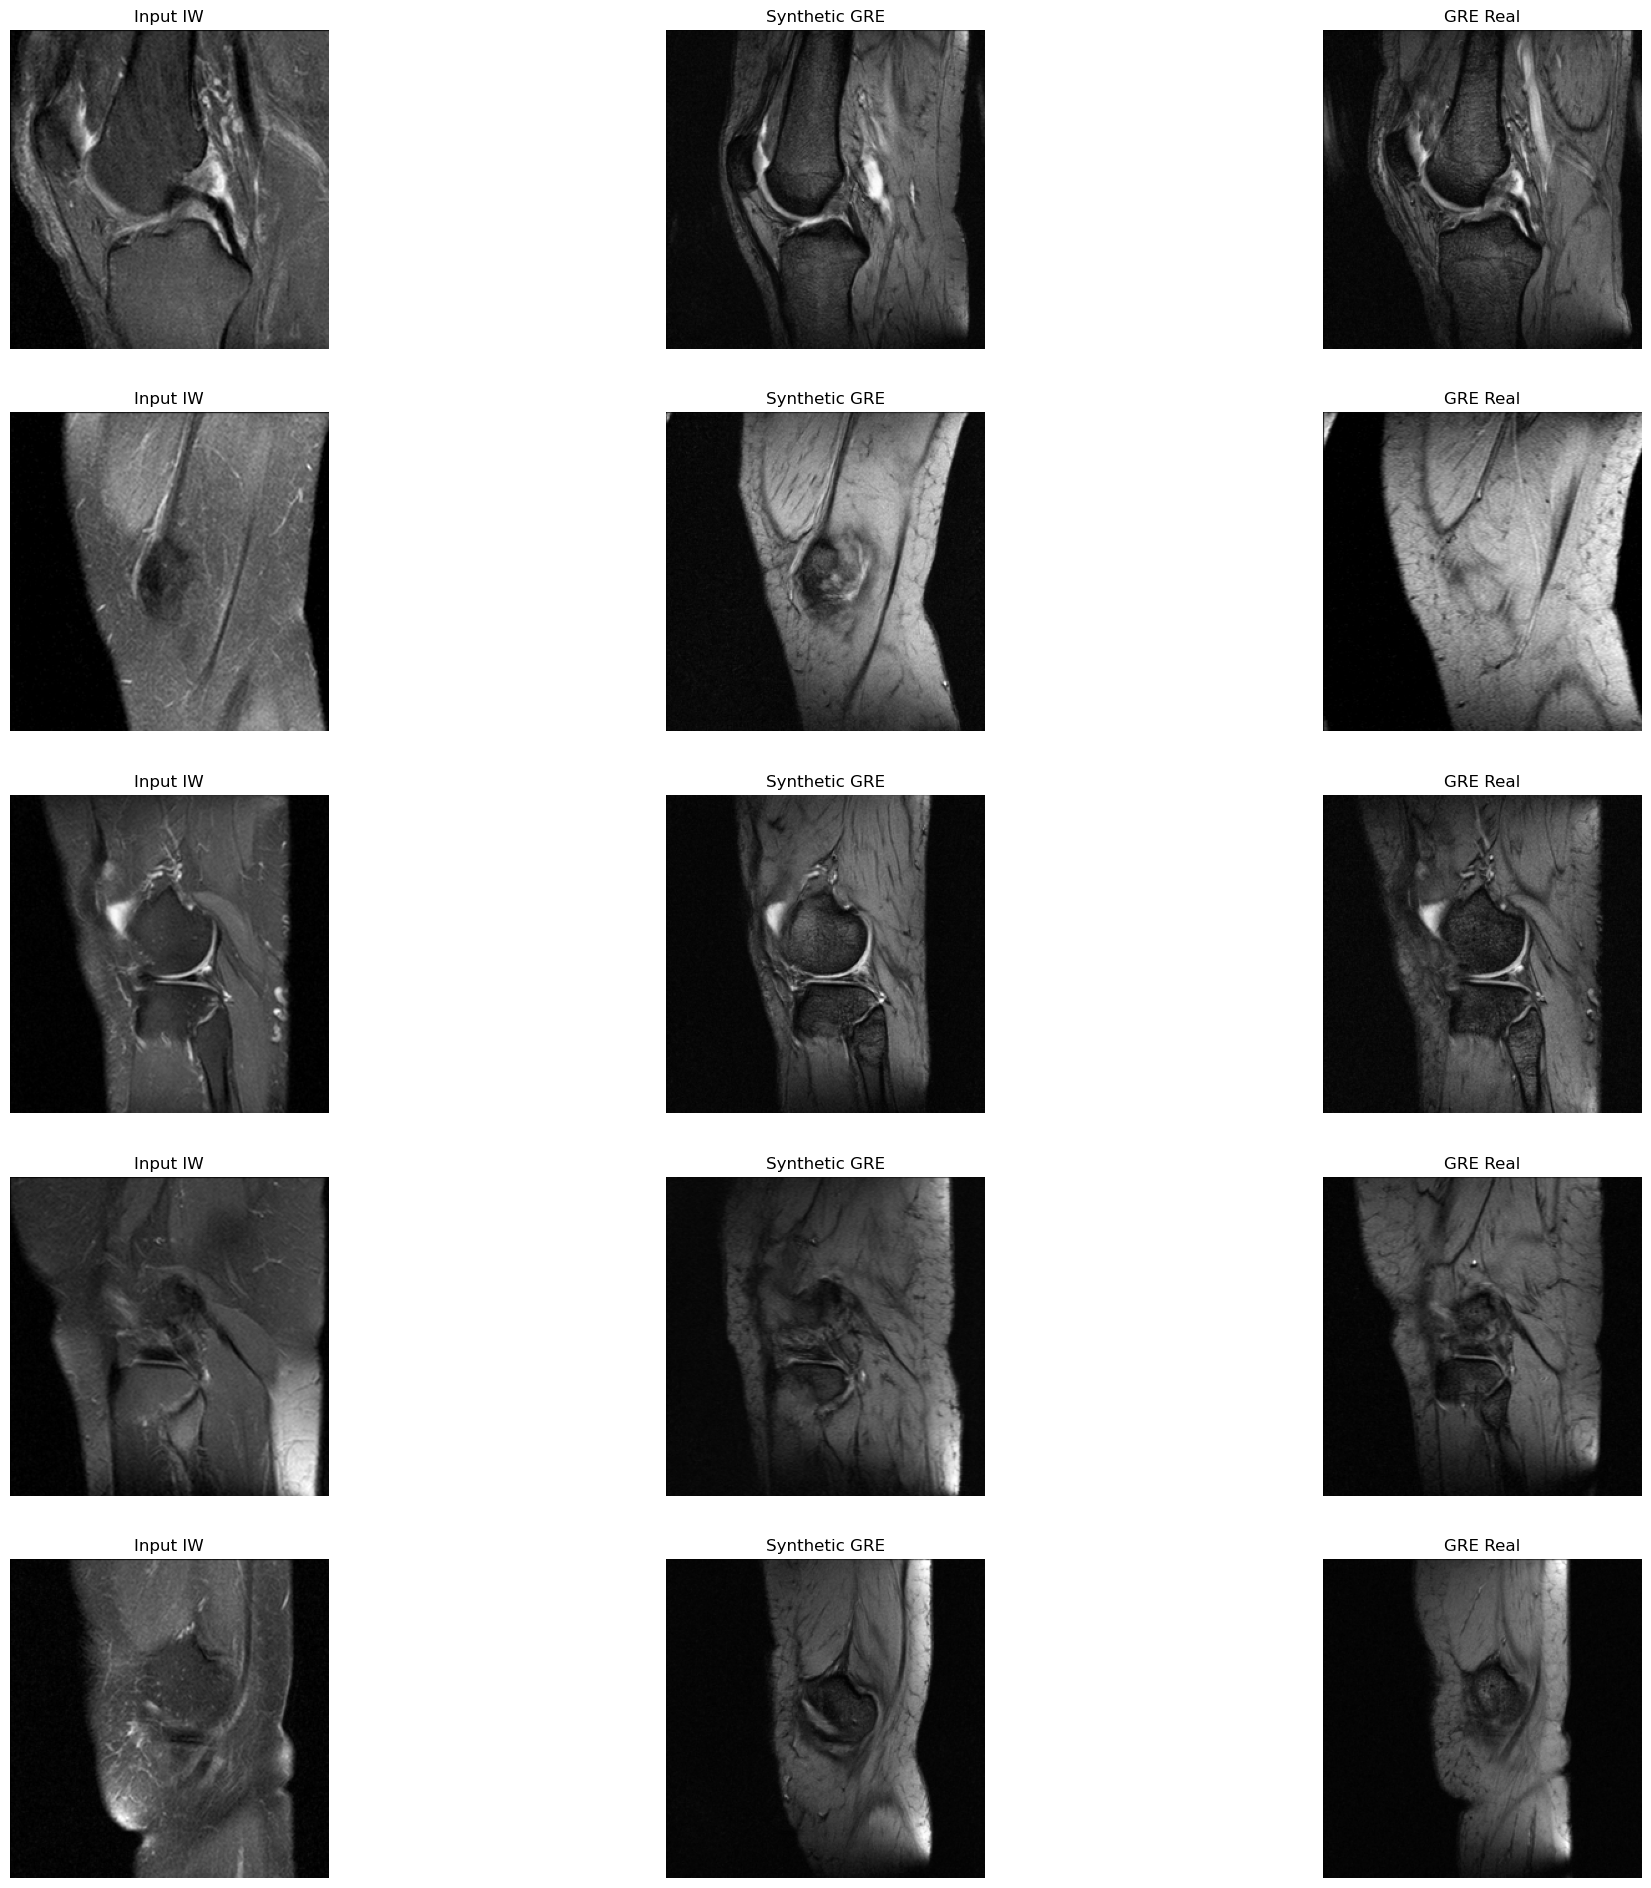

In [23]:
_, ax = plt.subplots(5, 3, figsize=(24, 24)) 
for i, img in enumerate(dataset_test.take(5)):            
    image_A, image_B = img
    prediction = med_generator(image_A, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image_A = (image_A[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    image_B = (image_B[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(image_A, cmap = 'gray')
    ax[i, 1].imshow(prediction, cmap = 'gray')
    ax[i, 2].imshow(image_B, cmap = 'gray')
    ax[i, 0].set_title("Input IW")
    ax[i, 1].set_title("Synthetic GRE")
    ax[i, 2].set_title("GRE Real")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()